# Random Forest con Codificación Ordinal y Selección de Variables

## 1. Introducción

En este notebook construiremos un modelo de clasificación utilizando Random Forest para predecir el rendimiento global de estudiantes en las pruebas Saber Pro.

Aplicaremos codificación ordinal para variables categóricas (`LabelEncoder`), limpiaremos los datos faltantes, y seleccionaremos las variables más relevantes (`feature_importances_`) usando la importancia de características del modelo.

## 2. Preprocesamiento

### 2.1. Carga del dataset

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import gdown
file_id = '1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'train.csv', quiet=False)
df = pd.read_csv("train.csv")

Downloading...
From (original): https://drive.google.com/uc?id=1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY
From (redirected): https://drive.google.com/uc?id=1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY&confirm=t&uuid=278eb75d-e586-4240-8ce2-8cb5490dd5c4
To: /content/train.csv
100%|██████████| 144M/144M [00:01<00:00, 84.1MB/s]


### 2.2. Limpieza de datos (valores faltantes)

In [ ]:
# Eliminar columna duplicada si existe
if 'FAMI_TIENEINTERNET.1' in df.columns:
    df.drop(columns=['FAMI_TIENEINTERNET.1'], inplace=True)

In [ ]:
# Imputación por categoría "missing"
missing_replacements = {
    'ESTU_VALORMATRICULAUNIVERSIDAD': 'Sin información',
    'ESTU_HORASSEMANATRABAJA': 'Sin información',
    'FAMI_ESTRATOVIVIENDA': 'Sin información',
    'FAMI_EDUCACIONPADRE': 'No sabe / No responde',
    'FAMI_EDUCACIONMADRE': 'No sabe / No responde',
    'FAMI_TIENECOMPUTADOR': 'Sin información',
    'FAMI_TIENEINTERNET': 'Sin información',
    'FAMI_TIENEAUTOMOVIL': 'Sin información'
}
for col, value in missing_replacements.items():
    df[col] = df[col].fillna(value)

In [ ]:
# Imputación con moda
mode_columns = ['FAMI_TIENELAVADORA', 'ESTU_PAGOMATRICULAPROPIO']
for col in mode_columns:
    moda = df[col].mode()[0]
    df[col] = df[col].fillna(moda)

### 2.3. Codificación ordinal de variables categóricas

In [ ]:
from sklearn.preprocessing import LabelEncoder

def codificar(df):
    df_cod = df.copy()
    for col in df_cod.columns:
        if df_cod[col].dtype == 'object':
            le = LabelEncoder()
            df_cod[col] = le.fit_transform(df_cod[col].astype(str))
    return df_cod

df_encoded = codificar(df)

### 2.4. Selección de variables con Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['ID', 'PERIODO', 'coef_1', 'coef_2', 'coef_3', 'coef_4', 'RENDIMIENTO_GLOBAL'])
y = df_encoded['RENDIMIENTO_GLOBAL']

In [ ]:
# Modelo preliminar para evaluar importancias
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

RandomForestClassifier(random_state=42)

In [ ]:
# Ordenar características según importancia
importancias = pd.Series(rf.feature_importances_, index=X.columns)
importantes = importancias.sort_values(ascending=False).head(30).index.tolist()

X = X[importantes]

## 3. Modelo de Machine Learning

### 3.1. Configuración del modelo Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)

### 3.2. Entrenamiento del modelo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=200, n_jobs=-1,
                       random_state=42)

### 3.3. Evaluación con validación cruzada

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=3, scoring='accuracy')
print("Accuracy promedio:", scores.mean())

Accuracy promedio: 0.411122023105363


## 4. Generación de predicciones

### 4.1. Preprocesar test.csv

In [ ]:
# Subir kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isabedoyaudea","key":"2499231d0432529fc8eef395ea983615"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Descargar y cargar test
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia --force
!unzip -o udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip -d ./

df_test = pd.read_csv("test.csv")
df_test.head()

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.10GB/s]
Archive:  udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
  inflating: ./submission_example.csv  
  inflating: ./test.csv              
  inflating: ./train.csv             


,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,coef_1,coef_2,coef_3,coef_4
0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Si,No,N,Si,Si,Si,Primaria completa,0.328,0.219,0.317,0.247
1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Técnica o tecnológica completa,0.227,0.283,0.296,0.324
2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.285,0.228,0.294,0.247
3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Si,No,N,No,No,No,Primaria incompleta,0.160,0.408,0.217,0.294
4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.209,0.283,0.306,0.286


In [ ]:
# Imputaciones similares
for col, value in missing_replacements.items():
    if col in df_test.columns:
        df_test[col] = df_test[col].fillna(value)
for col in mode_columns:
    if col in df_test.columns:
        moda = df_test[col].mode()[0]
        df_test[col] = df_test[col].fillna(moda)

In [ ]:
# Codificación
for col in df_test.columns:
    if df_test[col].dtype == 'object':
        le = LabelEncoder()
        df_test[col] = le.fit_transform(df_test[col].astype(str))

In [ ]:
# Selección de variables
X_kaggle = df_test[importantes]

### 4.2. Predecir valores

In [ ]:
y_pred = model.predict(X_kaggle)
y_pred

array([0, 3, 0, ..., 2, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score

# Calculamos el accuracy en el conjunto de validación
y_val_pred = model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_val_pred)
print(f"🎯 Accuracy - Random Forest: {accuracy_rf:.4f}")

🎯 Accuracy - Random Forest: 0.4147


### 4.3 Visualización

🎯 Distribución de clases predichas:
0    43007
1    42489
2    24696
3    28308
Name: count, dtype: int64


/tmp/ipython-input-35-2563329483.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="viridis")


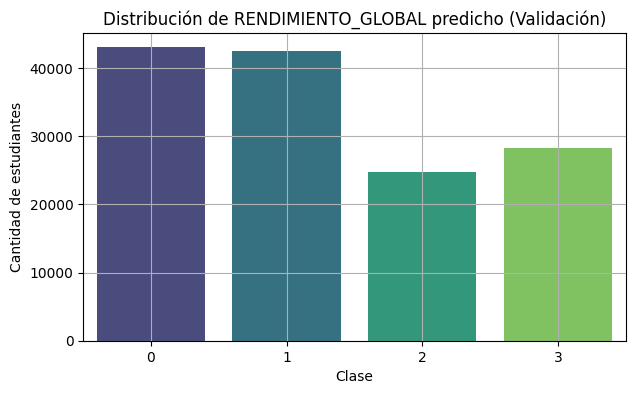

<Figure size 700x600 with 0 Axes>

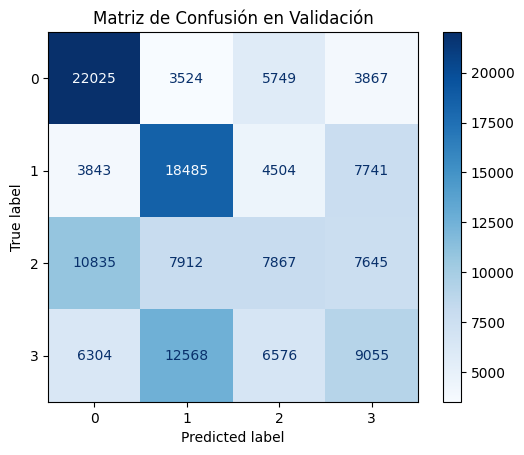

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tabla de distribución de clases predichas
pred_counts = pd.Series(y_val_pred).value_counts().sort_index()
print("🎯 Distribución de clases predichas:")
print(pred_counts)

# Gráfico de barras
plt.figure(figsize=(7, 4))
sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="viridis")
plt.title("Distribución de RENDIMIENTO_GLOBAL predicho (Validación)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de estudiantes")
plt.grid(True)
plt.show()

# Matriz de confusión
cm = confusion_matrix(y_test, y_val_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plt.figure(figsize=(7, 6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Matriz de Confusión en Validación")
plt.grid(False)
plt.show()

In [ ]:
# Unir ID y predicción
pred_df = pd.DataFrame({
    'ID': df_test['ID'],
    'RENDIMIENTO_GLOBAL_PREDICHO': y_pred
})

# Mostrar una muestra
pred_df.sample(10, random_state=42)

,ID,RENDIMIENTO_GLOBAL_PREDICHO
296289,556619,0
117604,164711,2
23209,593195,0
46670,834287,1
154912,481918,0
68397,752367,1
163718,335592,2
173028,246940,2
221001,555334,3
122158,460044,0


### 4.4. Envío a Kaggle

In [ ]:
# Generar el archivo de submission
submission_rf = pd.DataFrame({
    'ID': df_test['ID'],
    'RENDIMIENTO_GLOBAL': le.inverse_transform(y_pred)  # Decodificar etiquetas
})
submission_rf.to_csv('solution.csv', index=False)
print("🎯 Random Forest: archivo 'solution.csv' generado")

🎯 Random Forest: archivo 'solution.csv' generado


## 5. Conclusiones

- El modelo Random Forest no logró generar resultados útiles para esta competencia, obteniendo un accuracy de 0.00000 en Kaggle.
- Aunque la selección de variables redujo la dimensionalidad y la codificación ordinal fue sencilla de aplicar, el modelo probablemente sufrió por no estar adecuadamente ajustado o por no capturar relaciones complejas entre atributos.
- Este resultado sugiere que Random Forest, sin ajustes avanzados o más elaborados, no es adecuado para este tipo de clasificación multiclase.